In [135]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [77]:
def test_train_split(df, wt_col, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n, weights=wt_col.apply(lambda x: wt_col.value_counts()[x])).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

In [26]:
TRAIN_MONTH = '2015_05_28'
TEST_MONTH = '2016_05_28'

TRAIN_FILE = 'data/train_' + TRAIN_MONTH + '.csv'
ADDED_PRODUCTS_FILE = 'data/added_product_' + TRAIN_MONTH + '.csv'

TEST_FILE = 'data/train_' + TEST_MONTH + '.csv'

HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

In [27]:
train = pd.read_csv(TRAIN_FILE, header=None, names=HEADER)
test = pd.read_csv(TEST_FILE, header=None, names=HEADER)
added_products = pd.read_csv(ADDED_PRODUCTS_FILE)

combined = pd.concat((train, test)).reset_index(drop=True)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
def process_data_from_original_dataframe(combined):
    # fixing age
    combined['age'] = pd.to_numeric(combined['age'], errors='coerce')

    combined.loc[combined.age < 18, "age"] = \
        combined.loc[(combined.age > 18) &
                     (combined.age <= 30), "age"].mean(skipna=True)
    combined.loc[combined.age > 100, "age"] = \
        combined.loc[(combined.age > 30) &
                     (combined.age <= 100), "age"].mean(skipna=True)
    combined['age'].fillna(combined['age'].mean(), inplace=True)
    combined['age'] = combined['age'].astype(int)

    # fix ind_nuevo..
    combined.loc[combined.ind_nuevo.isnull(), 'ind_nuevo'] = 1

    # fix antiguedad
    combined['antiguedad'] = pd.to_numeric(combined['antiguedad'],
                                           errors='coerce')
    combined.loc[combined.antiguedad.isnull(), 'antiguedad'] = \
        combined.antiguedad.min()
    combined.loc[combined.antiguedad < 0, 'antiguedad'] = 0

    # fix indrel
    combined.loc[combined.indrel.isnull(), 'indrel'] = 1

    # drop useless cols
    combined.drop(['tipodom', 'cod_prov'], axis=1, inplace=True)

    # fix ind_actividad_cliente
    combined.loc[combined.ind_actividad_cliente.isnull(),
                 "ind_actividad_cliente"] = \
        combined.ind_actividad_cliente.median()

    # fix city name
    combined.loc[combined.nomprov ==
                 "CORU\xc3\x91A, A", "nomprov"] = "CORUNA, A"
    combined.loc[combined.nomprov.isnull(), 'nomprov'] = 'UNKNOWN'

    # fix incomes
    # combined.renta = pd.to_numeric(combined.renta, errors='coerce')
    grouped = combined.groupby('nomprov').\
        agg({'renta': lambda x: x.median(skipna=True)}).reset_index()
    new_incomes = pd.merge(combined, grouped,
                           how='inner',
                           on='nomprov').loc[:, ['nomprov', 'renta_y']]

    new_incomes = new_incomes.\
        rename(columns={"renta_y": "renta"}).\
        sort_values("renta").sort_values("nomprov")

    combined.sort_values("nomprov", inplace=True)
    combined = combined.reset_index()
    new_incomes = new_incomes.reset_index()
    combined.loc[combined.renta.isnull(), "renta"] = \
        new_incomes.loc[combined.renta.isnull(), "renta"].median()
    combined.sort_values(by='fecha_dato', inplace=True)

    # rest of the columns
    string_data = combined.select_dtypes(include=["object"])
    missing_columns = [col for col in string_data
                       if string_data[col].isnull().any()]
    del string_data

    combined.loc[combined.indfall.isnull(), 'indfall'] = 'N'
    combined.loc[combined.tiprel_1mes.isnull(), 'tiprel_1mes'] = 'A'
    combined.tiprel_1mes = combined.tiprel_1mes.astype('category')

    map_dict = {
        '1.0': '1',
        '1': '1',
        '3.0': '3',
        'P': 'P',
        3.0: '3',
        2.0: '2',
        '3': '3',
        '2.0': '2',
        '4.0': '4',
        '4': '4',
        '2': '2',
        1.0: '1',
        4.0: '4'
    }

    combined.indrel_1mes.fillna('P', inplace=True)
    combined.indrel_1mes = combined.indrel_1mes.apply(lambda x: map_dict[x])
    combined.indrel_1mes = combined.indrel_1mes.astype('category')

    unknown_cols = [col for col in missing_columns if
                    col not in ['indfall', 'tiprel_1mes', 'indrel_1mes']]
    for col in unknown_cols:
        combined.loc[combined[col].isnull(), col] = "UNKNOWN"

    # feature cols
    feature_cols = combined.iloc[:1, ].filter(regex="ind_+.*ult.*").\
        columns.values
    for col in feature_cols:
        combined.loc[combined[col].isnull(), col] = 0
        combined[col] = combined[col].astype(int)

    del combined['ult_fec_cli_1t'], combined['fecha_alta']

    encoders = []
    for col in ['sexo', 'indrel_1mes', 'pais_residencia', 'ind_empleado',
                'segmento', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp',
                'canal_entrada', 'indfall', 'nomprov']:
        temp_enc = LabelEncoder()
        temp_enc.fit(combined[col])
        combined[col] = temp_enc.transform(combined[col])
        encoders.append(temp_enc)
    return combined, encoders



In [29]:
combined, encoders = process_data_from_original_dataframe(combined)

In [30]:
train = combined.loc[combined.fecha_dato == '2015-05-28', :].\
    reset_index(drop=True)
test = combined.loc[combined.fecha_dato == '2016-05-28', :].\
    reset_index(drop=True)

del train['index'], test['index']
del train['fecha_dato'], test['fecha_dato']

added_products.set_index('ncodpers', inplace=True)
train.set_index('ncodpers', inplace=True)
test.set_index('ncodpers', inplace=True)

label_encoder = LabelEncoder()
label_encoder.fit(added_products.added_product)
added_products['encoded_products'] = label_encoder.\
    transform(added_products['added_product'])


/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
y_test, y_train, rows = test_train_split(added_products, added_products.added_product, 0.2)

In [118]:
y_test.set_index('ncodpers', inplace=True)
y_train.set_index('ncodpers', inplace=True)

x_test = train.loc[y_test.index, :]
x_train = train.loc[y_train.index, :]
x_main = train.loc[added_products.ncodpers, :]

xgb_train = xgb.DMatrix(x_train, label=y_train.encoded_products)
xgb_test = xgb.DMatrix(x_test, label=y_test.encoded_products)
xgb_main = xgb.DMatrix(x_main, label=added_products.encoded_products)

In [106]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 100
plist = param.items()

evallist = [(xgb_train, 'train'), (xgb_test, 'test')]

In [82]:
xgb_model = xgb.train(plist, xgb_train, num_rounds, evallist)

[0]	train-mlogloss:2.91695	test-mlogloss:2.89295
[1]	train-mlogloss:2.78428	test-mlogloss:2.74432
[2]	train-mlogloss:2.67408	test-mlogloss:2.62109
[3]	train-mlogloss:2.58225	test-mlogloss:2.51935
[4]	train-mlogloss:2.50057	test-mlogloss:2.42917
[5]	train-mlogloss:2.42803	test-mlogloss:2.34987
[6]	train-mlogloss:2.36473	test-mlogloss:2.2802
[7]	train-mlogloss:2.30716	test-mlogloss:2.21796
[8]	train-mlogloss:2.25327	test-mlogloss:2.15882
[9]	train-mlogloss:2.20658	test-mlogloss:2.10837
[10]	train-mlogloss:2.16042	test-mlogloss:2.05771
[11]	train-mlogloss:2.11782	test-mlogloss:2.01103
[12]	train-mlogloss:2.07801	test-mlogloss:1.96713
[13]	train-mlogloss:2.04092	test-mlogloss:1.92638
[14]	train-mlogloss:2.00635	test-mlogloss:1.88817
[15]	train-mlogloss:1.9744	test-mlogloss:1.85316
[16]	train-mlogloss:1.94397	test-mlogloss:1.81992
[17]	train-mlogloss:1.91513	test-mlogloss:1.7886
[18]	train-mlogloss:1.88809	test-mlogloss:1.75926
[19]	train-mlogloss:1.8628	test-mlogloss:1.73179
[20]	train-mlo

In [91]:
def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

In [84]:
train_preds = xgb_model.predict(xgb_train)

In [92]:
map7eval(train_preds, xgb_train)

('MAP@7', 0.7103245897712301)

In [93]:
xgb.cv(param, xgb_train, num_boost_round=30, feval=map7eval, maximize=True)

,test-MAP@7-mean,test-MAP@7-std,train-MAP@7-mean,train-MAP@7-std
0,0.669332,0.002044,0.680815,0.001256
1,0.675710,0.000481,0.687612,0.001874
2,0.676099,0.001248,0.688466,0.000582
3,0.677237,0.001592,0.690113,0.000550
4,0.677956,0.001428,0.691729,0.000519
5,0.679512,0.000887,0.693152,0.000724
6,0.679722,0.001539,0.693466,0.001082
7,0.679662,0.001692,0.694305,0.000889
8,0.679902,0.001745,0.694484,0.000749
9,0.679991,0.001892,0.695293,0.000254


In [102]:
xgb_model_sample = xgb.train(plist, xgb_train, 10, evallist, feval=map7eval)

[0]	train-MAP@7:0.681549	test-MAP@7:0.756019
[1]	train-MAP@7:0.680291	test-MAP@7:0.75506
[2]	train-MAP@7:0.685471	test-MAP@7:0.756498
[3]	train-MAP@7:0.687238	test-MAP@7:0.759133
[4]	train-MAP@7:0.689095	test-MAP@7:0.757696
[5]	train-MAP@7:0.690202	test-MAP@7:0.758414
[6]	train-MAP@7:0.690442	test-MAP@7:0.759372
[7]	train-MAP@7:0.690682	test-MAP@7:0.760091
[8]	train-MAP@7:0.691101	test-MAP@7:0.760091
[9]	train-MAP@7:0.692089	test-MAP@7:0.76045


In [121]:
orig_params = {'colsample_bytree': 0.6,
                'eta': 0.1,
                'gamma': 0.4,
                'max_delta_step': 7,
                'max_depth': 4,
                'min_child_weight': 1,
                'nthread': 4,
                'objective': 'multi:softprob',
                'scale_pos_weight': 0,
                'subsample': 0.75,
                'silent': 1
            }

tup = lambda t: list(itertools.izip(itertools.repeat(t[0]), t[1]))

def get_list_of_params(params_range):
    pr = list(map(tup, params_range.items()))
    pro = map(dict, list(itertools.product(*pr)))
    return pro


def grid_search_xgb(params_range_dict):
    grid_params_list = get_list_of_params(params_range_dict)
    p = Pool(2)
    maps = map(get_map_of_xgb, grid_params_list)
    p.close()
    p.join()
    sorted_maps = sorted(maps, cmp = lambda x, y: cmp(x['map'], y['map']), reverse = True)
    print "top map results", sorted_maps[:3]
    return sorted_maps

def get_map_of_xgb(grid_param):
    cv_params = dict(orig_params)
    num_class = {'num_class': len(label_encoder.classes_)}
    cv_params.update(num_class)
    cv_params.update(grid_param)
    # print orig_params, grid_param
    temp_cv = xgb.cv(cv_params, xgb_main, num_boost_round = 20, stratified=True,
             early_stopping_rounds = 20, feval = map7eval, maximize = True)
    temp_map = temp_cv['test-MAP@7-mean'][temp_cv.shape[0]-1]
    grid_param['map'] = temp_map
    # print "cv results", grid_param
    return grid_param

param_range1 = {
    'max_depth': range(2, 7, 2),
    'min_child_weight': range(1, 7, 2)
}
param_range2 = {
    'gamma': [i/10.0 for i in range(0, 6)],
    'colsample_bylevel': [i/10.0 for i in range(5, 10)]
}
param_range3 = {
    'max_delta_step': range(3, 10, 2)
}
param_range4 = {
    'subsample': [i/100.0 for i in range(80, 100, 5)],
    'colsample_bytree': [i/100.0 for i in range(80, 100, 5)]
}

In [124]:


for param_range in [param_range1, param_range2, param_range3, param_range4]:
    result = None
    try:
        result = grid_search_xgb(param_range)
    except Exception, e:
        print e
        print traceback.format_exc()

    if result != None:
        temp_param = result[0]
        del(temp_param['map'])
        orig_params.update(temp_param)
        


top map results [{'map': 0.69603499999999985, 'max_depth': 4, 'min_child_weight': 1}, {'map': 0.69601100000000005, 'max_depth': 4, 'min_child_weight': 3}, {'map': 0.69577133333333341, 'max_depth': 4, 'min_child_weight': 5}]
top map results [{'map': 0.69627466666666671, 'gamma': 0.4, 'colsample_bylevel': 0.9}, {'map': 0.69617866666666683, 'gamma': 0.0, 'colsample_bylevel': 0.9}, {'map': 0.69617866666666683, 'gamma': 0.2, 'colsample_bylevel': 0.9}]
top map results [{'map': 0.69627466666666671, 'max_delta_step': 7}, {'map': 0.69605899999999998, 'max_delta_step': 10}, {'map': 0.69605899999999998, 'max_delta_step': 11}]
top map results [{'subsample': 0.95, 'colsample_bytree': 0.95, 'map': 0.69934099999999999}, {'subsample': 0.9, 'colsample_bytree': 0.95, 'map': 0.69919733333333323}, {'subsample': 0.7, 'colsample_bytree': 0.9, 'map': 0.69917300000000004}]


In [128]:
orig_params['num_class'] = len(label_encoder.classes_)
orig_params

{'colsample_bylevel': 0.9,
 'colsample_bytree': 0.95,
 'eta': 0.1,
 'gamma': 0.4,
 'max_delta_step': 7,
 'max_depth': 4,
 'min_child_weight': 1,
 'nthread': 4,
 'num_class': 22,
 'objective': 'multi:softprob',
 'scale_pos_weight': 0,
 'silent': 1,
 'subsample': 0.95}

In [129]:
xgb_model = xgb.train(orig_params, xgb_main, 200, evallist, feval=map7eval)

[0]	train-MAP@7:0.67565	test-MAP@7:0.76596
[1]	train-MAP@7:0.67538	test-MAP@7:0.769793
[2]	train-MAP@7:0.678105	test-MAP@7:0.771829
[3]	train-MAP@7:0.679273	test-MAP@7:0.772667
[4]	train-MAP@7:0.679872	test-MAP@7:0.772188
[5]	train-MAP@7:0.680351	test-MAP@7:0.772907
[6]	train-MAP@7:0.680381	test-MAP@7:0.772787
[7]	train-MAP@7:0.68092	test-MAP@7:0.773626
[8]	train-MAP@7:0.68089	test-MAP@7:0.773386
[9]	train-MAP@7:0.681429	test-MAP@7:0.773386
[10]	train-MAP@7:0.681639	test-MAP@7:0.774105
[11]	train-MAP@7:0.682088	test-MAP@7:0.773985
[12]	train-MAP@7:0.682387	test-MAP@7:0.774344
[13]	train-MAP@7:0.682986	test-MAP@7:0.774344
[14]	train-MAP@7:0.683016	test-MAP@7:0.774464
[15]	train-MAP@7:0.683166	test-MAP@7:0.774584
[16]	train-MAP@7:0.683375	test-MAP@7:0.774823
[17]	train-MAP@7:0.683555	test-MAP@7:0.775063
[18]	train-MAP@7:0.683735	test-MAP@7:0.774823
[19]	train-MAP@7:0.684064	test-MAP@7:0.774823
[20]	train-MAP@7:0.684453	test-MAP@7:0.774344
[21]	train-MAP@7:0.684633	test-MAP@7:0.773626
[22

In [131]:
final_test = xgb.DMatrix(test)
preds = xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'ind_ahor_fin_ult1':'ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 931453/931453 [11:56<00:00, 1300.61it/s]


In [134]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/submissions/5.xgb_trained_on_jun_2015_only_added_users_cv_params_tuning.csv'
description = 'xgb model trained on june 2015 on added products and tuned cv params:\n' + str(orig_params)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True)

Compressing file
Compression done
Uploading submission data/submissions/5.xgb_trained_on_jun_2015_only_added_users_cv_params_tuning.csv.zip
Upload done


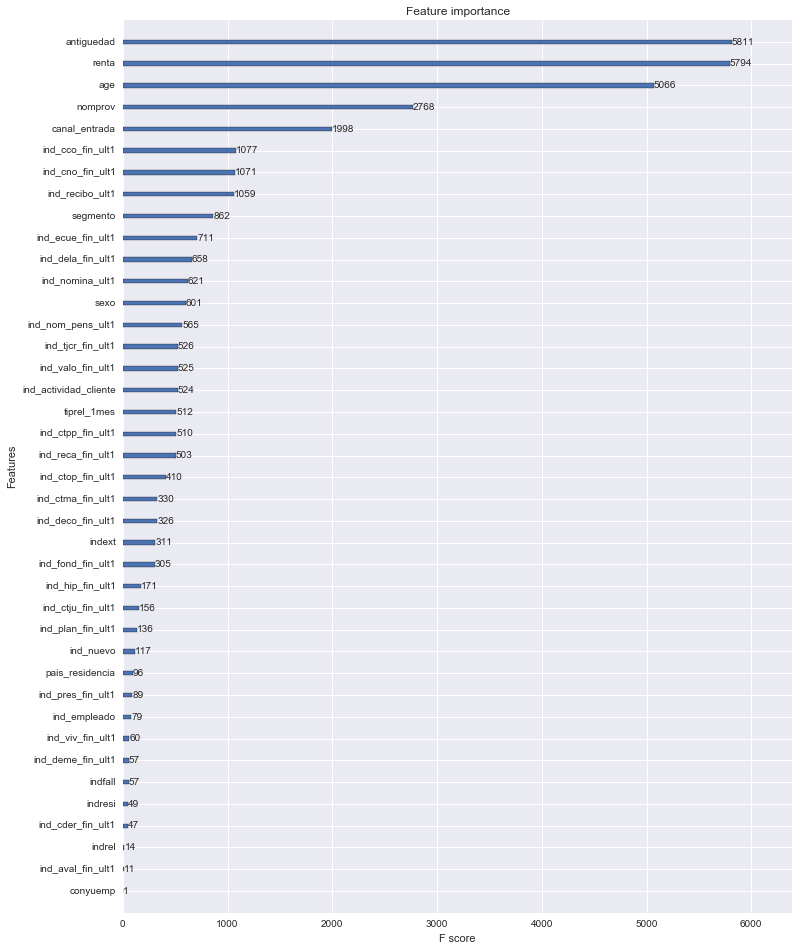

In [136]:
xgb.plot_importance(xgb_model)

In [138]:
gc.collect()

1587